# EWMA, SES and Holts-Winter models

Exponentially-Weighted Moving Average (EWMA) is the component used in most forecasting models, like **Simple Exponential Smoothing** (SES), **Holts** and **Holts-Winter**. You can simply use EWMA to highlight any trends or patterns in the behaviour of the time series by creating a column of the EWMA values for the original time series using Pandas `ewm` function.

You will demonstrate these models using the airline passenger count dataset, which records the number of passengers per month from 1949 to 1960 (12 years).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('data/airline_passengers.csv', index_col='Month', parse_dates=True)

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
# 12 years worth of data

df.shape

(144, 1)

In [5]:
# Check for null values

df.isna().sum()

Passengers    0
dtype: int64

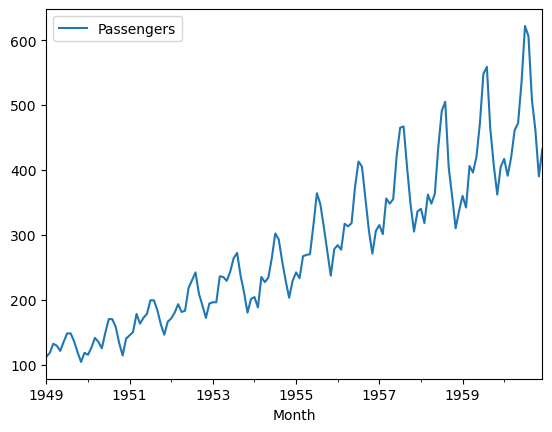

In [6]:
df.plot();

**Plot shows cyclical behaviour with increasing amplitude - spikes in numbers halfway through each year. There seems to be very little randomness in the behaviour of the time series, which makes it an excellent candidate for machine-learning (pattern-recognition). It is hard to tell whether the trend is linear or just increases over time (many real-world phenomena grow exponentially over time).**

## Time series analysis with EWMA

**To compose the exponentially-weighted moving averages, you use `ewm()` function in Pandas. You must first set an alpha value, which you can optimize like a hyperparameter:**

* closer to zero for a 'smoother' plot
* closer to one for a more 'jagged' plot

In [7]:
alpha = 0.2

In [8]:
# Add EWMA column to dataset - adjust to False for recursive moving average (which is what we want)

df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [9]:
df.head()

,Passengers,EWMA
Month,,
1949-01-01,112,112.0000
1949-02-01,118,113.2000
1949-03-01,132,116.9600
1949-04-01,129,119.3680
1949-05-01,121,119.6944


In [10]:
# Note what datatype ewm() generates - 'moving window'

type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

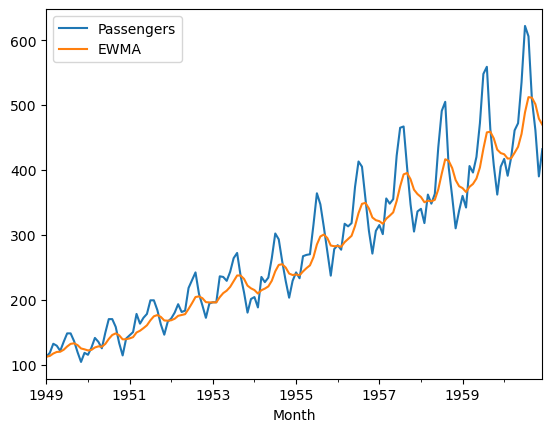

In [11]:
df.plot();

**EWMA is a delayed and dampened version of original time series (similar to SMA). Play around with alpha value to see how it affects the moving average, e.g. 0.8 produces a plot almost the same as the original time series.** 

### Calculate EWMA manually

In [12]:
# Calculate EWMA manually to see under-the-hood

manual_ewma = []

for x in df['Passengers'].to_numpy():
    # If there is no previous value, it can't do calculation
    if len(manual_ewma) > 0:
        xhat = alpha * x + (1 - alpha) * manual_ewma[-1] 
    else:
        xhat = x 
        
    manual_ewma.append(xhat)


In [13]:
df['manual_EWMA'] = manual_ewma

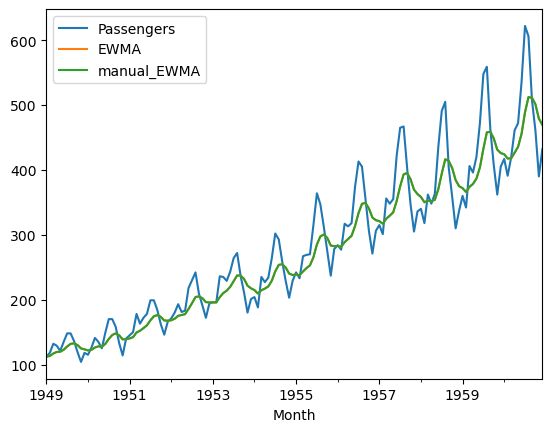

In [14]:
# Exactly the same

df.plot();

## Build SES model

To start, you will build an SES model with StatsModels **`SimpleExpSmoothing`** function, through which you pass the time series to model, i.e. the original time series. It returns a Holts-Winter object using EWMA logic under-the-hood to predict for future timesteps.

In [15]:
# Drop manual column since it is exact replica - keep it clean!

df.drop('manual_EWMA', axis=1, inplace=True)

In [16]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [17]:
# We know the timesteps are monthly but set index frequency to monthly to avoid warning messages

df.index.freq = 'MS'

In [18]:
# StatsModel does not calculate moving average like above

ses = SimpleExpSmoothing(df['Passengers'])

In [19]:
# Add initialization method for traditional method to calculate moving average (default is 'estimated')

ses = SimpleExpSmoothing(df['Passengers'], initialization_method='legacy-heuristic')

In [20]:
# YOU WOULD NOT USE PARAMETERS IN ACTUAL MACHINE-LEARNING TASK -  this is just to show EWMA under-the-hood

res = ses.fit(smoothing_level=alpha, optimized=False)

In [21]:
res

In [22]:
# Predict for entire dataset (returns Pandas series)

res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [23]:
# Add predictions to original dataset

df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [24]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [25]:
# Are predictions and fitted values the same?

np.allclose(df['SES'], res.fittedvalues)

True

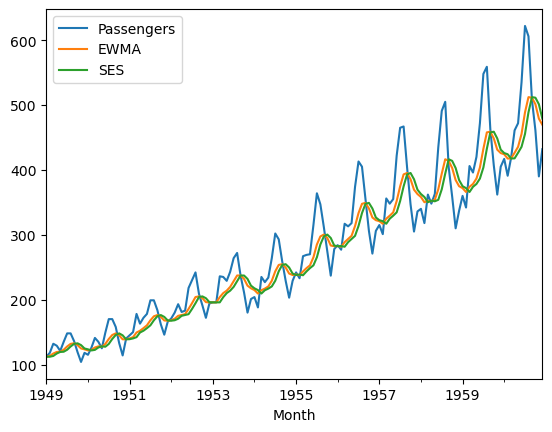

In [26]:
df.plot();

**Results from the SES model are different from Pandas `ewm` - they seem to have shifted up by one. This is actually correct, since it is making a prediction based on the moving average of the previous step, given the moving average of the timestep before that. That means it is one step behind since it is forecasting.**

**Notice that the second row in the SES column of the DataFrame, the value has not changed - it has remained 112 while EWMA has increased as expected. See the following rows, and you can see that the values have shifted up one, which you can confirm by using `shift()` function and plotting the shifted SES column.**

In [28]:
df.head(6)

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.00000,112.0000
1949-02-01,118,113.20000,112.0000
1949-03-01,132,116.96000,113.2000
1949-04-01,129,119.36800,116.9600
1949-05-01,121,119.69440,119.3680
1949-06-01,135,122.75552,119.6944


In [29]:
# Shift SES values back one row to see if the values match up

df['SES-1'] = df['SES'].shift(-1)

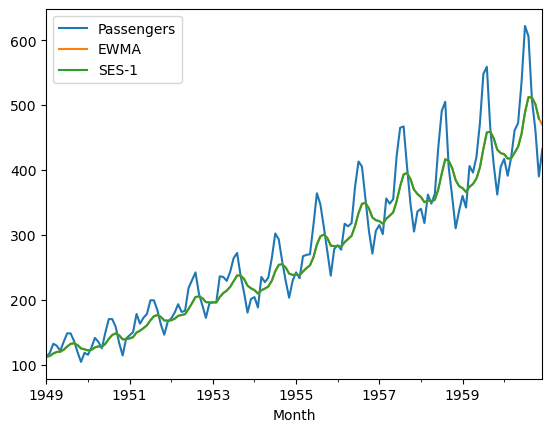

In [30]:
df[['Passengers', 'EWMA', 'SES-1']].plot();

**As you can see, the values now match up when you shift SES values back one row, which means that the SES model worked as expected. Now you can run predictions by creating a training and test set from the dataset.**

### Forecast with SES model

In [31]:
N_test = 12

# Training set is all rows upto last 12 rows
train = df.iloc[:-N_test]

# Test set is last 12 rows
test = df.iloc[-N_test:]

In [32]:
# Re-build SES model for forecasting (i.e. no parameters when 'fitting')

ses = SimpleExpSmoothing(train['Passengers'], initialization_method='legacy-heuristic')

res = ses.fit()

In [33]:
# Create Boolean indices for whether it is training or test set from the original DataFrame

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [34]:
train_idx

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [35]:
test_idx

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

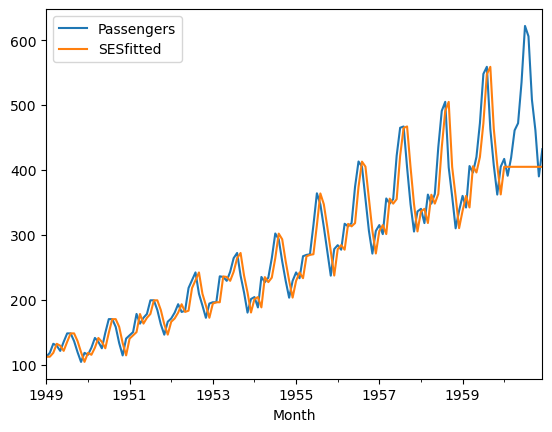

In [36]:
# Add predictions for training set to DataFrame
df.loc[train_idx, 'SESfitted'] = res.fittedvalues

# Add predictions for test set to DataFrame
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)

# Plot predictions against time series
df[['Passengers', 'SESfitted']].plot();

**As expected, the fitted values for the training set match up to the original time series, lagging by one month. The predictions for the test set are all the same, i.e. no trend or seasonality captured, just the same moving average at each future timestep. The SES model is basically doing 'naive' forecasting, by copying the last known value.**

In [37]:
# SES model parameters

res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

**As you can see from the model parameters, the optimum alpha level is 0.995 which is basically 1! This means that the model is reacting very quickly to the original time series, indicating that it cares more about recent timesteps and less about the previous timesteps.**

## Build Holt Linear Trend model

Just by seeing the original time series plotted out, you can tell that there is a steady increase in airline passengers, and the Holts model can help ascertain whether that is linear or based on other factors, e.g. drop in inflation, global economy etc.

StatsModel provides the **`Holt`** function to model a time series that shows evidence of a linear trend, and it works exactly like `SimpleExpSmoothing` function.

In [38]:
from statsmodels.tsa.holtwinters import Holt

In [39]:
# First, train model on entire dataset

holt = Holt(df['Passengers'], initialization_method='legacy-heuristic')

In [40]:
res_h = holt.fit()

In [41]:
# Obtain model predictions for dataset

df['Holt'] = res_h.fittedvalues

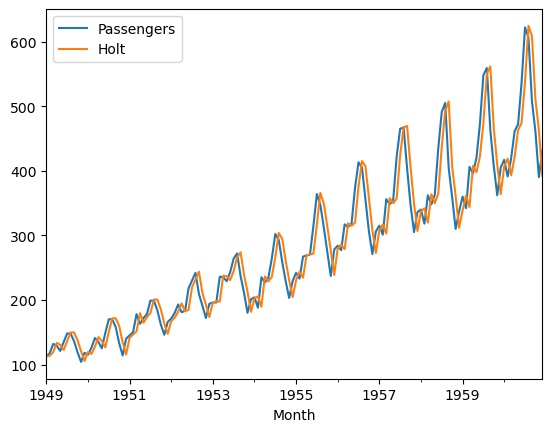

In [42]:
df[['Passengers', 'Holt']].plot();

**Again, note that the model forecasts the values one timestep behind, as if tracking the time series values. You can confirm this by shifting the forecasted values back one to match up the values.**

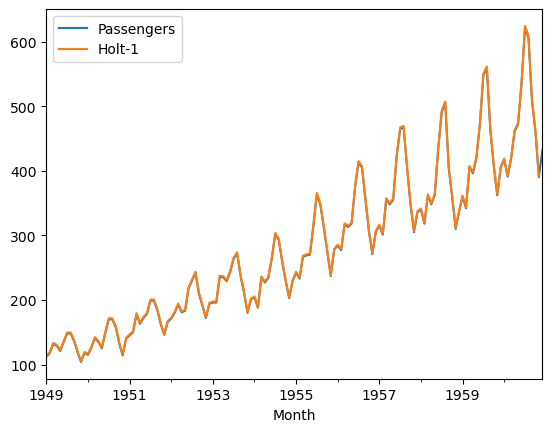

In [43]:
# DO NOT ACTUALLY SHIFT VALUES - this is just to show that fitted values lag by one timestep

df['Holt-1'] = df['Holt'].shift(-1)
df[['Passengers', 'Holt-1']].plot();

In [44]:
holt = Holt(train['Passengers'], initialization_method='legacy-heuristic')

res_h = holt.fit()

In [45]:
# Add the Holt predictions to original DataFrame

df.loc[train_idx, 'Holt'] = res_h.fittedvalues
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)

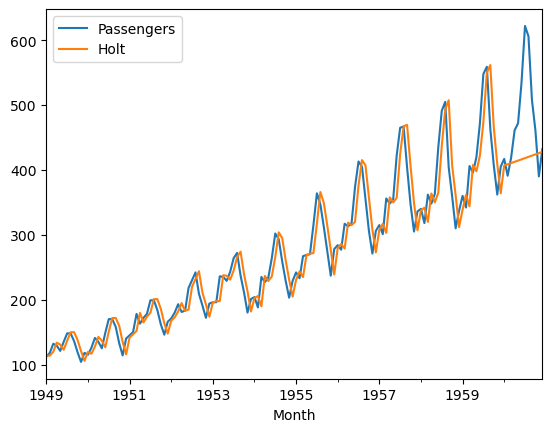

In [46]:
df[['Passengers', 'Holt']].plot();

**As you can see, the prediction line trends upwards, which the model uses to track the movement of the values.**

## Holt-Winters model

StatsModel package provides **`ExponentialSmoothing`** function, which you use to build the Holt-Winters model, i.e. to capture seasonality as well as the trend. Seasonality refers to cyclical patterns in the time series, i.e. there is significant 'noise' in the data at regular times, which was clearly present in the original time series.

There are two methods to combine the seasonality and trend components together to forecast - **additive** and **multiplicative**. You can think of these methods as hyperparameters when building the model.

In [50]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [51]:
hw = ExponentialSmoothing(train['Passengers'], 
                          initialization_method='legacy-heuristic', 
                          trend='add', 
                          seasonal='add', 
                          seasonal_periods=12)


In [52]:
res_hw = hw.fit()

In [53]:
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues

In [54]:
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

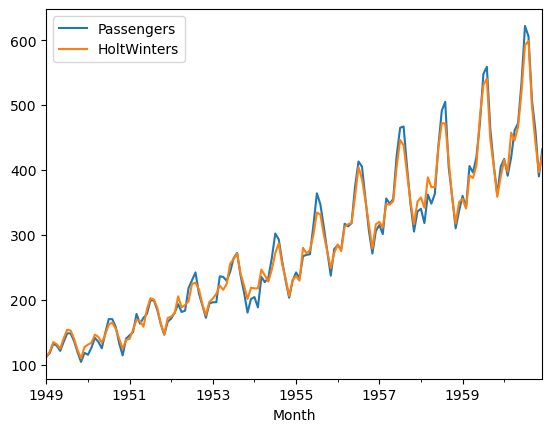

In [55]:
df[['Passengers', 'HoltWinters']].plot();

**Using the additive method, the predicted values now look more like the original time series, following the linear trend and seasonal patterns. Most noticeable is that the predictions no longer lag behind the time series.**

### Run metrics on the Holt-Winters model

Now that the model fits the time series decently, you can run performance metrics to assess accuracy on the test set. In this case, you can create your own custom metric functions for Root Mean Squared Errors (RMSE) and Mean Absolute Errors (MAE) measures.

In [56]:
def rmse(y, t):
    return np.sqrt(np.mean((y - t)**2))

In [57]:
def mae(y, t):
    return np.mean(np.abs(y - t))

In [58]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.624714430673352
Test RMSE: 16.978029847029934


In [59]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 9.006650631052384
Test MAE: 13.37759090303536


**The metrics for the test set are the ones that really matter - for additive method there is an average error of 13.38 and RMSE value of 16.98.**

### Additive vs Multiplicative Holt-Winters model

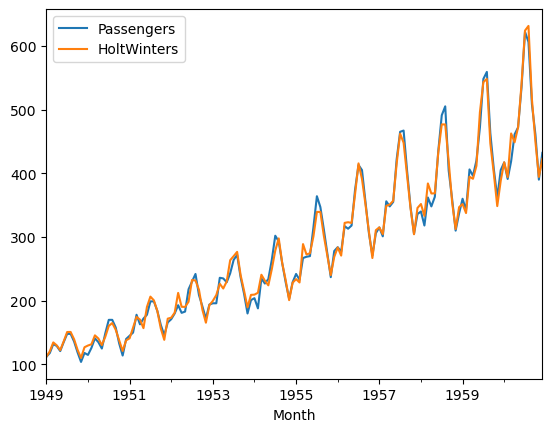

In [60]:
# ------------------------------  Additive trend & Multiplicative seasonality ------------------------------

hw = ExponentialSmoothing(train['Passengers'], 
                          initialization_method='legacy-heuristic', 
                          trend='add', 
                          seasonal='mul', 
                          seasonal_periods=12)

res_hw = hw.fit()

df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

df[['Passengers', 'HoltWinters']].plot();

In [61]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.767995205168011
Test RMSE: 15.810870232569963


In [62]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.604272329965027
Test MAE: 10.30368288348438


**RMSE improved by 1 unit & MAE improved by 3 units, which suggests that multiplicative seasonality captures the data better.**

C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


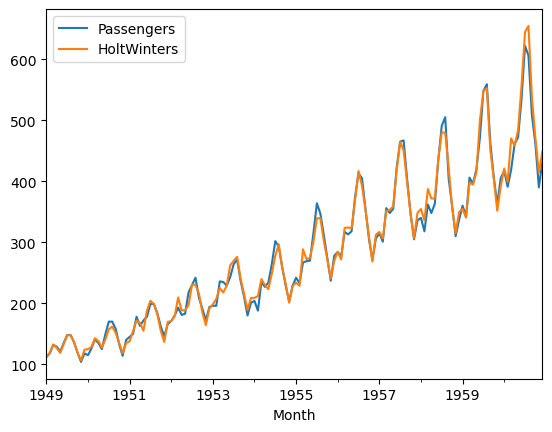

In [63]:
# ------------------------------  Multiplicative trend & Multiplicative seasonality ------------------------
# (RuntimeWarning happens in lecture also, and teacher did nothing...)

hw = ExponentialSmoothing(train['Passengers'], 
                          initialization_method='legacy-heuristic', 
                          trend='mul', 
                          seasonal='mul', 
                          seasonal_periods=12)

res_hw = hw.fit()

df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

df[['Passengers', 'HoltWinters']].plot();

In [64]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.61792487803932
Test RMSE: 25.80687515735493


In [65]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.112379992634933
Test MAE: 20.844988412204554


**Test MAE and RMSE dramatically got worse, by at least 10 points for both MAE and RMSE, when combining the trend multiplicatively. But note that the training MAE and RMSE improved...this means that the purely multiplicative model overfit to the training data, causing a worse result.**

**Remember, you can mix-and-match the additive & multiplicative methods when trying to forecast with Holt-Winters.**